In [36]:
#!/usr/bin/env python
# coding: utf-8

# This script is used to compare two ensemble outputs (e.g., gauge-based GMET and NLDAS-based GMET)
import os
os.environ["PROJ_LIB"] = '/glade/u/home/hongli/tools/miniconda3/envs/conda_hongli/share/proj'

from mpl_toolkits.basemap import Basemap
from pyproj import Proj
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime

def plot_basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,ax,lat_0,lon_0,ny,nx):

    m = Basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,resolution='l',projection='cyl', ax=ax)   
    m.drawstates(linewidth=1, linestyle='solid', color='grey')
    m.drawcountries(linewidth=1, linestyle='solid', color='k')
    m.drawcoastlines(linewidth=.75, linestyle='solid', color='k')

    # lat and lon with lables
    m.drawparallels(np.arange(np.floor(llcrnrlat),np.ceil(urcrnrlat),10),labels=[True,False,False,False],
                    dashes=[1,1], fontsize='xx-small', linewidth=0.2, color='grey') # Draw parallels (latitude lines)
    m.drawmeridians(np.arange(np.floor(llcrnrlon),np.ceil(urcrnrlon),15),labels=[False,False,False,True],
                    dashes=[1,1], fontsize='xx-small', linewidth=0.2, color='grey') # Draw meridians (longitude lines). Label [left, right, top, bottom]    

    return m

#======================================================================================================
# main script
root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet'   
stn_ens_dir = os.path.join(root_dir,'data/stn_ens_summary')
start_yr = 2013
end_yr = 2016

stn_grid_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth.nc')
nldas_grid_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth_deg_v1p1.nc')

result_dir = os.path.join(root_dir,'test_uniform_perturb')
test_folders = [d for d in os.listdir(result_dir)]
test_folders = sorted(test_folders)
scenario_num = len(test_folders)
intervals =  range(10,1,-1)

test_result_dir=os.path.join(root_dir, 'scripts/step25_rank_sum_test')
stn_vars=['pcp_error', 'pcp_error_2', 'tmean_error_2', 'trange_error_2']
nldas_vars=['pcp_error_update', 'pcp_error_2_update', 'tmean_error_2', 'trange_error_2']
var_num = len(stn_vars)

time_format = '%Y-%m-%d'
plot_date_start = '2013-01-01'
plot_date_end = '2016-12-31'
plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)

dpi_value = 150
output_dir=os.path.join(root_dir, 'scripts/step26_plot_rank_sum_test_crps')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
#======================================================================================================
print('Read gridinfo mask')
# get xy mask from gridinfo.nc
f_stn_grid = xr.open_dataset(stn_grid_file)
stn_mask_xy = f_stn_grid['mask'].values[:] # (y, x). 1 is valid. 0 is invalid.

f_nldas_grid = xr.open_dataset(nldas_grid_file)
nldas_mask_xy = f_nldas_grid['mask'].values[:] # (y, x). 1 is valid. 0 is invalid.
latitude = f_nldas_grid['latitude'].values[:]
longitude = f_nldas_grid['longitude'].values[:]

# commonly available area
mask_xy = (stn_mask_xy==0) | (nldas_mask_xy==0) 

#======================================================================================================
print('Read rank-sum test results and crps')
# read rank-sum test results and crps
pcp_test_dict = {} # empty dictionary. will have 9 integer keys for 9 scenarios
pcp_2_test_dict = {} 
tmean_2_test_dict = {} 
trange_2_test_dict = {} 

pcp_crps_dict = {} # empty dictionary. will have 9 integer keys for 9 scenarios
pcp_2_crps_dict = {} 
tmean_2_crps_dict = {} 
trange_2_crps_dict = {} 

for i in range(scenario_num):

    test_folder = test_folders[i] 
#     print(test_folder)
    
    for j in range(var_num):
        stn_var = stn_vars[j]
        nldas_var = nldas_vars[j]
        
        output_file_namebase = test_folder+'_'+nldas_var
        ofile = os.path.join(test_result_dir, output_file_namebase+'_HypoTest_005.txt')
        test = np.loadtxt(ofile,delimiter=',')
        test = np.where(test==-999,np.nan,test)

        ofile = os.path.join(test_result_dir, output_file_namebase+'_CRPS.txt')
        crps = np.loadtxt(ofile,delimiter=',')
        crps = np.where(crps==-999,np.nan,crps)

        if j == 0:
            pcp_test_dict[i] = test
            pcp_crps_dict[i] = crps
        elif j == 1:
            pcp_2_test_dict[i] = test
            pcp_2_crps_dict[i] = crps
        elif j == 2:
            tmean_2_test_dict[i] = test
            tmean_2_crps_dict[i] = crps
        elif j == 3:
            trange_2_test_dict[i] = test
            trange_2_crps_dict[i] = crps

#======================================================================================================    
# create a white-blue linear colormap
print('Create colormap')

# reference: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
cmap = mpl.cm.get_cmap('jet') # get the blue color of jet 
c0 = cmap(0.0)
top = mpl.colors.LinearSegmentedColormap.from_list("", ["white",c0])
newcolors = np.vstack(top(np.linspace(0, 1, int(256))))
newcmp = mpl.colors.LinearSegmentedColormap.from_list("WhiteBlue", newcolors)

#======================================================================================================
print('Plot')
for k in range(var_num): # loop through variables
# for k in range(2,3): 
    stn_var = stn_vars[k]
    nldas_var = nldas_vars[k]
    print(stn_var)

    # select data dictionary
    if k == 0:
        test_dict = pcp_test_dict
        crps_dict = pcp_crps_dict
    elif k == 1:
        test_dict = pcp_2_test_dict
        crps_dict = pcp_2_crps_dict
    elif k == 2:
        test_dict = tmean_2_test_dict
        crps_dict = tmean_2_crps_dict
    elif k == 3:
        test_dict = trange_2_test_dict
        crps_dict = trange_2_crps_dict

    # vmin adn vmax
    vmin=np.nanmin([np.nanmin(crps_dict[s]) for s in range(scenario_num)])
    vmax=np.nanmax([np.nanmax(crps_dict[s]) for s in range(scenario_num)])
    
    # plot
    nrow = 3 # prcp, tmean, tmin, tmax, trange
    ncol = 3 # stn_ens mean, nldsa_ens mean, stn_ens std, nldas_ens std
    fig, ax = plt.subplots(nrow, ncol, figsize=(8,8*0.65))

    llcrnrlon = longitude[0,0]
    urcrnrlon = longitude[-1,-1]
    llcrnrlat = latitude[0,0]
    urcrnrlat = latitude[-1,-1]
    lat_0=0.5*(llcrnrlat+urcrnrlat)
    lon_0=0.5*(llcrnrlon+urcrnrlon)
    (ny,nx)=np.shape(longitude)
    
    for i in range(nrow):
        for j in range(ncol):
    
            scenario_id = i*ncol+j
            print('scenario ',scenario_id)
        
            # plot Basemap
            m = plot_basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,ax[i,j],lat_0,lon_0,ny,nx) # plot Basemap 
            
            # select data for each subplot
            test = test_dict[scenario_id]
            crps = crps_dict[scenario_id]

            # plot data
            im1 = m.pcolormesh(longitude,latitude,crps,shading='flat',latlon=True,
                               cmap=newcmp,vmin=vmin,vmax=vmax,alpha=0.9) #newcmp
            
            zm = np.ma.masked_array(test, mask=(test==0))
            im2 = m.pcolormesh(longitude,latitude,zm,shading='flat',latlon=True,
                               cmap=plt.get_cmap('autumn'), hatch='x', alpha=0.15) 
            
            # title
            title_str = 'Scenario '+str(scenario_id+1) +' (interval = '+str(intervals[scenario_id])+')'
            ax[i,j].set_title(title_str, fontsize='xx-small', fontweight='semibold')

           # change subplot border width
            for axis in ['top','bottom','left','right']:
                ax[i,j].spines[axis].set_linewidth(0.5)
                
    # colorbar    
    fig.subplots_adjust(bottom=0.1, top=1, left = 0, right=1, 
                        wspace = 0.1, hspace = 0.25)
    cax = fig.add_axes([0.33, 0.05, 0.33, 0.02]) #[left, bottom, width, height]
    cbar = fig.colorbar(im1, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize='xx-small', length=2, width=1)

    # set the colorbar ticks and tick labels
    cbar.set_label(label='CRPS',size='xx-small')    

    # save plot
#     fig.tight_layout()
    output_filename = nldas_var+'.png'
    fig.savefig(os.path.join(output_dir, output_filename), dpi=dpi_value, 
                bbox_inches = 'tight', pad_inches = 0.05)
    plt.close(fig)

print('Done')


Read gridinfo mask
Read rank-sum test results and crps
Create colormap
Plot
pcp_error
scenario  0
scenario  1
scenario  2
scenario  3
scenario  4
scenario  5
scenario  6
scenario  7
scenario  8
pcp_error_2
scenario  0
scenario  1
scenario  2
scenario  3
scenario  4
scenario  5
scenario  6
scenario  7
scenario  8
tmean_error_2
scenario  0
scenario  1
scenario  2
scenario  3
scenario  4
scenario  5
scenario  6
scenario  7
scenario  8
trange_error_2
scenario  0
scenario  1
scenario  2
scenario  3
scenario  4
scenario  5
scenario  6
scenario  7
scenario  8
Done


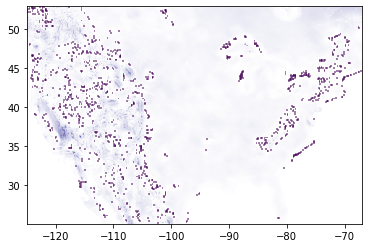

In [26]:
import matplotlib.pyplot as plt
# zm = np.ma.masked_less(test, 1)

zm = np.ma.masked_array(test, mask=(test==0))
# plt.imshow((zm),origin='lower')
# plt.pcolor(longitude,latitude, zm, hatch='/', alpha=0.5)
plt.pcolormesh(longitude,latitude,crps,shading='flat',
             cmap=newcmp,vmin=vmin,vmax=vmax, alpha=0.8) #newcmp
plt.pcolormesh(longitude,latitude,zm,shading='flat',
               hatch='x', alpha=0.5)
plt.show()

In [15]:
np.unique(test)

array([ 0.,  1., nan, ..., nan, nan, nan])

In [30]:
time_ensmean,plot_date_start_obj,plot_date_end_obj

(DatetimeIndex(['1970-01-01 03:33:04', '1970-01-01 03:33:05',
                '1970-01-01 03:33:06', '1970-01-01 03:33:07',
                '1970-01-01 03:33:08', '1970-01-01 03:33:09',
                '1970-01-01 03:33:10', '1970-01-01 03:33:11',
                '1970-01-01 03:33:12', '1970-01-01 03:33:13',
                ...
                '1970-01-01 03:45:05', '1970-01-01 03:45:06',
                '1970-01-01 03:45:07', '1970-01-01 03:45:08',
                '1970-01-01 03:45:09', '1970-01-01 03:45:10',
                '1970-01-01 03:45:11', '1970-01-01 03:45:12',
                '1970-01-01 03:45:13', '1970-01-01 03:45:14'],
               dtype='datetime64[ns]', length=731, freq=None),
 datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2016, 12, 31, 0, 0))